In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# rujukan dataset : https://www.kaggle.com/aturner374/eighty-years-of-canadian-climate-data
data = pd.read_csv('Canadian_climate_history.csv')

In [3]:
# memenuhi kriteria point 1: Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
data.tail()

,LOCAL_DATE,MEAN_TEMPERATURE_CALGARY,TOTAL_PRECIPITATION_CALGARY,MEAN_TEMPERATURE_EDMONTON,TOTAL_PRECIPITATION_EDMONTON,MEAN_TEMPERATURE_HALIFAX,TOTAL_PRECIPITATION_HALIFAX,MEAN_TEMPERATURE_MONCTON,TOTAL_PRECIPITATION_MONCTON,MEAN_TEMPERATURE_MONTREAL,TOTAL_PRECIPITATION_MONTREAL,MEAN_TEMPERATURE_OTTAWA,TOTAL_PRECIPITATION_OTTAWA,MEAN_TEMPERATURE_QUEBEC,TOTAL_PRECIPITATION_QUEBEC,MEAN_TEMPERATURE_SASKATOON,TOTAL_PRECIPITATION_SASKATOON,MEAN_TEMPERATURE_STJOHNS,TOTAL_PRECIPITATION_STJOHNS,MEAN_TEMPERATURE_TORONTO,TOTAL_PRECIPITATION_TORONTO,MEAN_TEMPERATURE_VANCOUVER,TOTAL_PRECIPITATION_VANCOUVER,MEAN_TEMPERATURE_WHITEHORSE,TOTAL_PRECIPITATION_WHITEHORSE,MEAN_TEMPERATURE_WINNIPEG,TOTAL_PRECIPITATION_WINNIPEG
29216,28-Dec-2019 00:00:00,-7.7,0.0,-10.4,0.0,2.1,0.0,0.5,NaN,1.3,0.0,-0.5,0.0,-0.5,0.3,-15.3,NaN,-4.3,5.3,3.0,0.2,5.3,3.0,-9.0,NaN,-4.7,0.0
29217,29-Dec-2019 00:00:00,-3.3,0.0,-8.6,0.0,-2.7,0.0,-3.8,NaN,-0.9,0.0,-3.4,0.8,-4.9,0.0,-15.6,NaN,-0.9,5.6,1.1,7.8,7.1,2.4,-2.8,NaN,-10.6,1.7
29218,30-Dec-2019 00:00:00,-1.6,0.0,-10.3,0.0,-3.5,0.0,-4.1,NaN,-2.3,13.4,-2.7,12.7,-5.7,2.7,-15.0,NaN,-0.7,0.7,5.6,8.0,7.5,5.8,-0.1,NaN,-10.9,0.1
29219,31-Dec-2019 00:00:00,4.3,0.0,-2.6,0.0,0.0,11.4,-1.0,NaN,-0.2,11.4,-0.7,6.6,-3.5,8.2,-8.2,NaN,-1.2,0.0,0.4,2.0,8.4,21.2,-1.1,NaN,-12.3,0.0
29220,01-Jan-2020 00:00:00,-0.3,0.0,-4.0,0.0,1.8,0.4,0.2,NaN,0.2,0.9,-0.5,0.0,-2.8,1.5,-7.9,NaN,-0.4,6.4,-1.7,0.0,7.8,0.8,-4.2,NaN,-7.0,0.0


In [4]:
data.isnull().sum()

LOCAL_DATE                           0
MEAN_TEMPERATURE_CALGARY           189
TOTAL_PRECIPITATION_CALGARY        173
MEAN_TEMPERATURE_EDMONTON         7657
TOTAL_PRECIPITATION_EDMONTON      7646
MEAN_TEMPERATURE_HALIFAX          7164
TOTAL_PRECIPITATION_HALIFAX       7226
MEAN_TEMPERATURE_MONCTON          2336
TOTAL_PRECIPITATION_MONCTON       2767
MEAN_TEMPERATURE_MONTREAL          755
TOTAL_PRECIPITATION_MONTREAL       730
MEAN_TEMPERATURE_OTTAWA             76
TOTAL_PRECIPITATION_OTTAWA          81
MEAN_TEMPERATURE_QUEBEC           1214
TOTAL_PRECIPITATION_QUEBEC        1227
MEAN_TEMPERATURE_SASKATOON        2473
TOTAL_PRECIPITATION_SASKATOON     3755
MEAN_TEMPERATURE_STJOHNS           808
TOTAL_PRECIPITATION_STJOHNS        822
MEAN_TEMPERATURE_TORONTO            74
TOTAL_PRECIPITATION_TORONTO         80
MEAN_TEMPERATURE_VANCOUVER          53
TOTAL_PRECIPITATION_VANCOUVER       55
MEAN_TEMPERATURE_WHITEHORSE       1691
TOTAL_PRECIPITATION_WHITEHORSE    4095
MEAN_TEMPERATURE_WINNIPEG

In [5]:
data_baru = data[:10000]
data_baru.tail()

,LOCAL_DATE,MEAN_TEMPERATURE_CALGARY,TOTAL_PRECIPITATION_CALGARY,MEAN_TEMPERATURE_EDMONTON,TOTAL_PRECIPITATION_EDMONTON,MEAN_TEMPERATURE_HALIFAX,TOTAL_PRECIPITATION_HALIFAX,MEAN_TEMPERATURE_MONCTON,TOTAL_PRECIPITATION_MONCTON,MEAN_TEMPERATURE_MONTREAL,TOTAL_PRECIPITATION_MONTREAL,MEAN_TEMPERATURE_OTTAWA,TOTAL_PRECIPITATION_OTTAWA,MEAN_TEMPERATURE_QUEBEC,TOTAL_PRECIPITATION_QUEBEC,MEAN_TEMPERATURE_SASKATOON,TOTAL_PRECIPITATION_SASKATOON,MEAN_TEMPERATURE_STJOHNS,TOTAL_PRECIPITATION_STJOHNS,MEAN_TEMPERATURE_TORONTO,TOTAL_PRECIPITATION_TORONTO,MEAN_TEMPERATURE_VANCOUVER,TOTAL_PRECIPITATION_VANCOUVER,MEAN_TEMPERATURE_WHITEHORSE,TOTAL_PRECIPITATION_WHITEHORSE,MEAN_TEMPERATURE_WINNIPEG,TOTAL_PRECIPITATION_WINNIPEG
9995,14-May-1967 00:00:00,11.4,0.0,10.0,0.0,7.3,0.0,7.0,0.0,7.0,0.0,8.9,0.0,7.3,0.0,9.2,0.0,4.5,0.3,8.1,1.3,9.7,5.1,4.4,0.0,3.4,0.0
9996,15-May-1967 00:00:00,8.4,0.0,11.4,0.5,7.5,7.9,6.1,6.4,7.8,4.1,7.2,2.0,6.4,14.5,11.4,0.0,6.2,0.0,8.6,0.3,12.8,0.0,7.8,0.0,6.7,0.0
9997,16-May-1967 00:00:00,12.5,0.0,11.2,0.0,7.2,4.6,6.2,6.1,7.3,0.0,7.0,0.0,4.5,0.3,11.1,0.0,5.0,5.6,7.5,0.0,13.1,0.0,5.0,0.3,8.3,0.0
9998,17-May-1967 00:00:00,12.5,1.3,12.0,0.0,8.1,0.0,8.6,2.3,10.6,0.3,11.4,0.0,7.8,0.0,16.4,0.0,4.5,0.0,12.8,0.8,15.3,0.8,4.4,3.3,15.9,0.0
9999,18-May-1967 00:00:00,9.2,0.0,7.8,0.0,8.1,2.5,7.5,5.1,8.6,1.3,7.8,2.0,5.9,0.0,10.0,0.0,7.5,0.0,12.8,3.3,12.5,0.0,7.2,0.0,9.7,0.0


In [6]:
# Mencari data yang menurut saya sudah bersih (tidak ada missing value)
data_baru.isnull().sum()

LOCAL_DATE                           0
MEAN_TEMPERATURE_CALGARY             0
TOTAL_PRECIPITATION_CALGARY          0
MEAN_TEMPERATURE_EDMONTON         7563
TOTAL_PRECIPITATION_EDMONTON      7538
MEAN_TEMPERATURE_HALIFAX          7084
TOTAL_PRECIPITATION_HALIFAX       7084
MEAN_TEMPERATURE_MONCTON             0
TOTAL_PRECIPITATION_MONCTON          4
MEAN_TEMPERATURE_MONTREAL          632
TOTAL_PRECIPITATION_MONTREAL       609
MEAN_TEMPERATURE_OTTAWA              0
TOTAL_PRECIPITATION_OTTAWA           0
MEAN_TEMPERATURE_QUEBEC           1188
TOTAL_PRECIPITATION_QUEBEC        1181
MEAN_TEMPERATURE_SASKATOON          11
TOTAL_PRECIPITATION_SASKATOON        0
MEAN_TEMPERATURE_STJOHNS           734
TOTAL_PRECIPITATION_STJOHNS        731
MEAN_TEMPERATURE_TORONTO             4
TOTAL_PRECIPITATION_TORONTO          0
MEAN_TEMPERATURE_VANCOUVER           1
TOTAL_PRECIPITATION_VANCOUVER        0
MEAN_TEMPERATURE_WHITEHORSE        823
TOTAL_PRECIPITATION_WHITEHORSE     822
MEAN_TEMPERATURE_WINNIPEG

In [10]:
dates = data_baru['LOCAL_DATE'].values
temp = data_baru['MEAN_TEMPERATURE_OTTAWA'].values

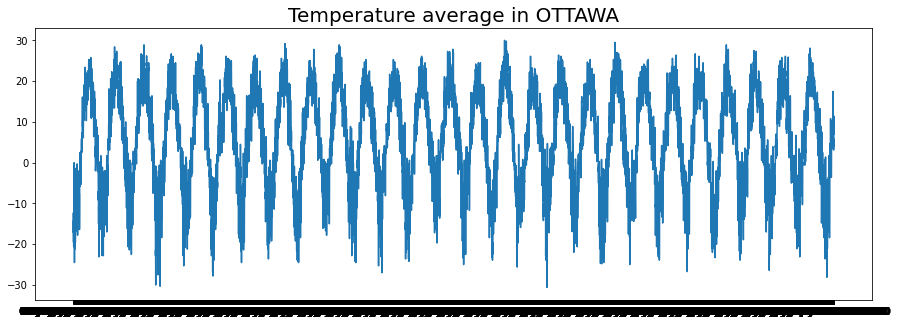

In [20]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average in OTTAWA',
         fontsize=20);

In [19]:
# Saya memutuskan untuk pembagian dataset secara manual
pembagian_data = len(data_baru)*0.8
pembagian_data = int(pembagian_data)

temp_train = temp[:pembagian_data]
temp_test = temp[pembagian_data:]

print(len(temp_train))
print(len(temp_test))

8000
2000


In [9]:
# Telah saya lakukan sesuai comment submission I untuk mengubah dari lambda w: (w[:-1], w[1:]) menjadi lambda w: (w[:-1], w[-1:])
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
# Telah saya lakukan sesuai notes point 2 submission I untuk menghitung MAE
minMae = (data_baru['MEAN_TEMPERATURE_OTTAWA'].max() - data_baru['MEAN_TEMPERATURE_OTTAWA'].min()) * 10/100
minMae

6.06

In [29]:
# Memutuskan untuk mengikuti contoh pada referensi: https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Answer.ipynb
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(temp_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(temp_train.shape)
test_set = windowed_dataset(temp_test, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], validation_data=test_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(8000,)
Epoch 1/100
31/31 [==============================] - 12s 388ms/step - loss: 16.4163 - mae: 16.9114 - val_loss: 15.3456 - val_mae: 15.8396
Epoch 2/100
31/31 [==============================] - 11s 356ms/step - loss: 15.3536 - mae: 15.8484 - val_loss: 14.1895 - val_mae: 14.6834
Epoch 3/100
31/31 [==============================] - 11s 359ms/step - loss: 13.8183 - mae: 14.3123 - val_loss: 12.7371 - val_mae: 13.2299
Epoch 4/100
31/31 [==============================] - 12s 378ms/step - loss: 12.2179 - mae: 12.7110 - val_loss: 11.5449 - val_mae: 12.0366
Epoch 5/100
31/31 [==============================] - 11s 359ms/step - loss: 11.0812 - mae: 11.5729 - val_loss: 10.8906 - val_mae: 11.3816
Epoch 6/100
31/31 [==============================] - 11s 350ms/step - loss: 10.5132 - mae: 11.0039 - val_loss: 10.5646 - val_mae: 11.0551
Epoch 7/100
31/31 [==============================] - 11s 356ms/step - 

(1e-08, 0.01, 0.0, 60.0)

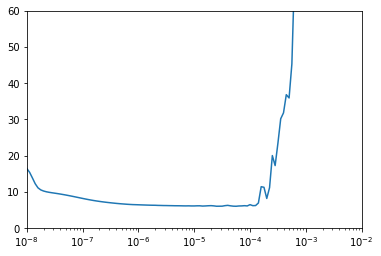

In [30]:
# Mencari Learning Rate terbaik berdasarkan hasil pelatihan model diatas
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 60])

In [36]:
# Mengikuti saran submission point 2: Mengimplementasikan Callback.
# Serta mengikuti saran dari Fahmi J: https://www.dicoding.com/academies/185/discussions/57239
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')is not None and logs.get('mae') < 6):
      print('\nPelatihan sudah selesai, MAE dibawah 10 persen')
      self.model.stop_training = True
callbacks = myCallback()

In [37]:
# Memutuskan untuk mengikuti contoh pada referensi: https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Answer.ipynb
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, callbacks=callbacks, validation_data=test_set)

Epoch 1/150
80/80 [==============================] - 12s 146ms/step - loss: 7.3177 - mae: 7.8033 - val_loss: 6.6521 - val_mae: 7.1362
Epoch 2/150
80/80 [==============================] - 11s 136ms/step - loss: 6.2618 - mae: 6.7457 - val_loss: 6.5213 - val_mae: 7.0056
Epoch 3/150
80/80 [==============================] - 11s 136ms/step - loss: 6.1068 - mae: 6.5900 - val_loss: 6.2048 - val_mae: 6.6874
Epoch 4/150
80/80 [==============================] - 11s 136ms/step - loss: 6.2303 - mae: 6.7143 - val_loss: 6.3006 - val_mae: 6.7834
Epoch 5/150
80/80 [==============================] - 11s 140ms/step - loss: 6.0389 - mae: 6.5217 - val_loss: 6.6418 - val_mae: 7.1264
Epoch 6/150
80/80 [==============================] - 11s 138ms/step - loss: 6.0369 - mae: 6.5201 - val_loss: 6.3580 - val_mae: 6.8413
Epoch 7/150
80/80 [==============================] - 11s 137ms/step - loss: 5.9691 - mae: 6.4518 - val_loss: 6.1480 - val_mae: 6.6303
Epoch 8/150
80/80 [==============================] - 11s 136ms

Text(0.5, 1.0, 'Error training')

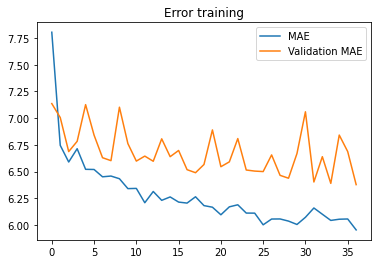

In [38]:
# mengikuti saran submission point 3: Membuat plot loss dan akurasi pada saat training dan validation.
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = 37
jarak_epochs = range(epochs)

plt.plot(jarak_epochs, mae, label='MAE')
plt.plot(jarak_epochs, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Error training')